In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas
import math

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.utils import np_utils
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [7]:
# Fix random seed for reproducibility
np.random.seed(7)

# Load the dataset
dataframe = pandas.read_csv('international-airline-passengers.csv',usecols=[1], skipfooter=3,engine='python')
#plt.plot(dataset)
#plt.show()
dataset = dataframe.values
dataset = dataset.astype('float32')

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

In [9]:
# Split the data into training and testing
trainSize = int(len(dataset)*0.67)
testSize = len(dataset) - trainSize

train, test = dataset[0:trainSize,:], dataset[trainSize:len(dataset),:]
print(len(train),len(test))



96 48


In [14]:
# X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1)
# Create a new dataset
def create_dataset(dataset, look_back=1):
    dataX, dataY = [],[]
    for i in range(len(dataset)-look_back-1):
        dataX.append(dataset[i:(i+look_back),0])
        dataY.append(dataset[i+look_back,0])
    return np.array(dataX),np.array(dataY)

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape the data into format [sample, steps, features]
trainX = np.reshape(trainX, (trainX.shape[0],1,trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0],1,testX.shape[1]))


In [15]:
# Create the model
model = Sequential()
model.add(LSTM(4,input_shape=look_back))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model.fit(trainX, trainY, verbose=1, epochs=100, batch_size=1)

c:\users\aashi\appdata\local\programs\python\python35\lib\site-packages\ipykernel\__main__.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  app.launch_new_instance()
c:\users\aashi\appdata\local\programs\python\python35\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(4, input_shape=(None, 1))`
  app.launch_new_instance()


Epoch 1/100
94/94 [==============================] - 4s - loss: 0.0413       
Epoch 2/100
94/94 [==============================] - 0s - loss: 0.0202         

In [16]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions (to ensure that performance is reported in the same units as the original data)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculate the root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0],trainPredict[:,0]))
print('Train Score: {:.2f}'.format(trainScore))
testScore = math.sqrt(mean_squared_error(testY[0],testPredict[:,0]))
print('Test Score: {:.2f}'.format(testScore))

Train Score: 22.92
Test Score: 47.53


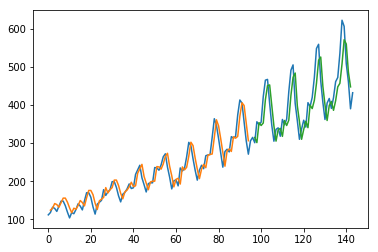

In [18]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()